## Step 1: Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

## Step 2: Loading dataset

In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive")
# !unzip /content/gdrive/MyDrive/Dataset3.zip
data_dir = r"C:\COMP6721\sign_alphabets\dataset5\B";

### Transforming Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(data_dir, transform = transform)

## Creating Dataloaders

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

num_classes = len(dataset.classes)
print("Number of classes: ",len(dataset.classes))
print("Number of images: ",len(dataset.samples))

Number of classes:  24
Number of images:  27820


In [5]:
# Splitting dataset into train, validation and test

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.2 * len(dataset))
extra_size = int(0 * len(dataset))
train_ds, val_ds, test_ds, extra_ds = random_split(dataset, [train_size, val_size, test_size, extra_size])
len(train_ds), len(val_ds), len(test_ds)

(19474, 2782, 5564)

In [6]:
from torch.utils.data import DataLoader
batch_size = 64

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [8]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break



In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss.detach(), 'train_acc': acc}

    def testing_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def training_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
       
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
       
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['test_loss'], result['val_loss'], result['train_acc'], result['test_acc'], result['val_acc']))

# Defining the model

In [10]:
from torchvision.models import shufflenet_v2_x1_0

model = shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features,num_classes)

c:\users\nisha\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\nisha\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

## Training the model

In [14]:
from torch.nn.modules import loss
from torch.optim.adam import Adam
num_epochs = 10
lr =  0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss();

In [16]:
from torch.autograd import Variable
#Model Training and saving best Model
best_accuracy = 0.0
train_acc_list = []
test_acc_list = []
val_acc_list = []
train_loss_list = []
test_loss_list = []
val_loss_list = []
epo = []
t1 = time.time()
for epoch in range(num_epochs):
  #evaluation and training on training dataset
  model.train()
  train_acc = 0.0
  train_loss = 0.0
  t2 = time.time()

  for i, (images, labels) in enumerate(train_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    # scheduler.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_acc += int(torch.sum(prediction==labels.data))

  train_acc = (train_acc / train_size)*100
  train_loss = train_loss / train_size
      
  #Evaluation on testing dataset
  model.eval()

  val_acc = 0.0
  correct2 = 0
  total2 = 0
  val_loss = 0.0

  for i, (images, labels) in enumerate(val_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    val_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    val_acc += int(torch.sum(prediction==labels.data))
    total2 += labels.size(0)
    correct2 += (prediction == labels).sum().item()

  val_loss = val_loss / val_size
  val_acc = (val_acc / val_size)*100
  print('Epoch[{}]({:.0f} sec)  Train Loss: {:.4f}, Train Accuracy:  {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}\n'.format(epoch+1,time.time()-t2,train_loss,train_acc,val_loss,val_acc))
  train_acc_list.append(train_acc)
  # test_acc_list.append(test_acc)
  val_acc_list.append(val_acc)
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)
  val_loss_list.append(val_loss)
  epo.append(epoch+1)

  if(val_acc>best_accuracy):
    torch.save(model.state_dict(), 'best_checkpoint.model')
    best_accuracy = val_acc

torch.save(model.state_dict(), type(model).__name__ + '-TL-dataset3-batch_size'+str(batch_size)+ 'lr-' + str(lr)+'epochs-'+str(num_epochs)+'.pth')

print("######## Training Finished in {:.0f} seconds ###########".format(time.time()-t1))
# print('Test Accuracy of the model on the {} test images: {} %'.format(total1, (correct1 / total1) * 100))
# print('Test Accuracy of the model on the {} validation images: {} %'.format(total2, (correct2 / total2) * 100))

Epoch[1](56 sec)  Train Loss: 0.8183, Train Accuracy:  76.1015, Val Loss: 0.2169, Val Accuracy: 87.8505

Epoch[2](42 sec)  Train Loss: 0.3008, Train Accuracy:  90.1304, Val Loss: 0.2315, Val Accuracy: 91.0137

Epoch[3](33 sec)  Train Loss: 0.2225, Train Accuracy:  92.3899, Val Loss: 0.2302, Val Accuracy: 91.5169

Epoch[4](33 sec)  Train Loss: 0.1725, Train Accuracy:  94.2898, Val Loss: 0.1055, Val Accuracy: 93.1704

Epoch[5](33 sec)  Train Loss: 0.1468, Train Accuracy:  94.8804, Val Loss: 0.0449, Val Accuracy: 92.9547

Epoch[6](33 sec)  Train Loss: 0.1192, Train Accuracy:  95.9228, Val Loss: 0.0667, Val Accuracy: 94.1409

Epoch[7](33 sec)  Train Loss: 0.1159, Train Accuracy:  96.0306, Val Loss: 0.1160, Val Accuracy: 93.6736

Epoch[8](34 sec)  Train Loss: 0.0967, Train Accuracy:  96.5903, Val Loss: 0.1037, Val Accuracy: 94.2487

Epoch[9](33 sec)  Train Loss: 0.0869, Train Accuracy:  96.9498, Val Loss: 0.0349, Val Accuracy: 93.9612

Epoch[10](33 sec)  Train Loss: 0.0852, Train Accuracy: 

# Model Evaluation

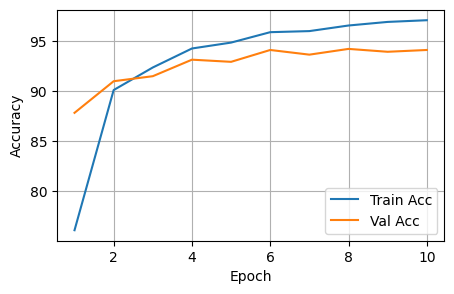

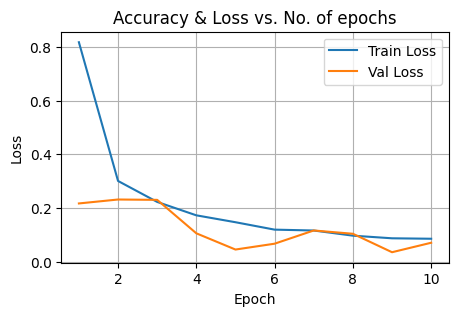

In [17]:
plt.rcParams["figure.figsize"] = (5,3)
fig, ax = plt.subplots()
plt.plot(epo, train_acc_list, label='Train Acc')
plt.plot(epo, val_acc_list, label='Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.plot(epo, train_loss_list, label='Train Loss')
plt.plot(epo, val_loss_list, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy & Loss vs. No. of epochs');

plt.grid()
plt.show()

Test Accuracy: 94.96764917325665


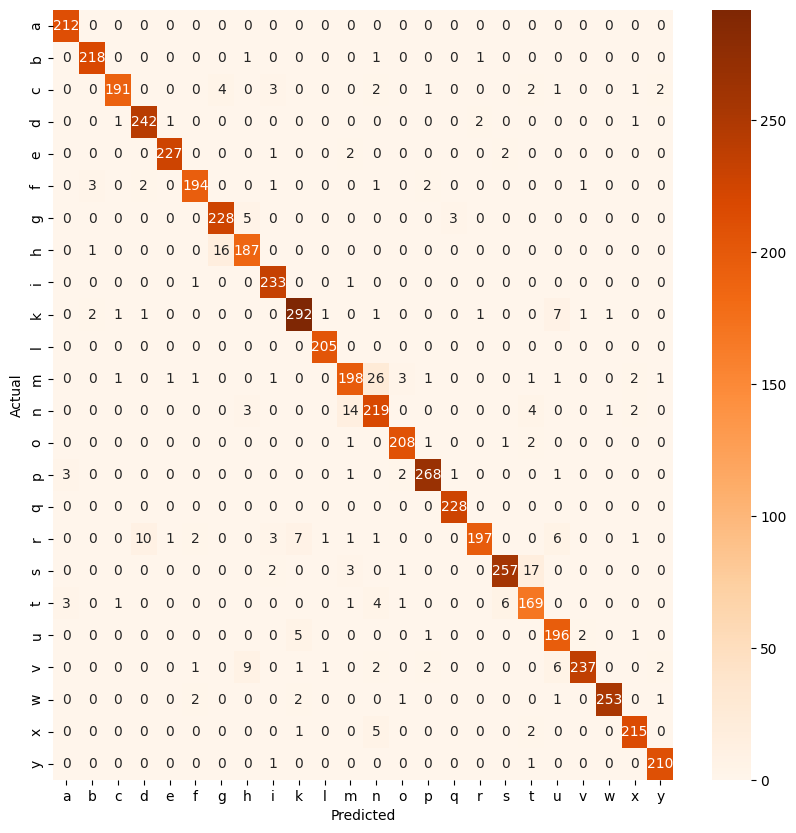

              precision    recall  f1-score   support

           a       0.97      1.00      0.99       212
           b       0.97      0.99      0.98       221
           c       0.98      0.92      0.95       207
           d       0.95      0.98      0.96       247
           e       0.99      0.98      0.98       232
           f       0.97      0.95      0.96       204
           g       0.92      0.97      0.94       236
           h       0.91      0.92      0.91       204
           i       0.95      0.99      0.97       235
           k       0.95      0.95      0.95       308
           l       0.99      1.00      0.99       205
           m       0.89      0.84      0.86       237
           n       0.84      0.90      0.87       243
           o       0.96      0.98      0.97       213
           p       0.97      0.97      0.97       276
           q       0.98      1.00      0.99       228
           r       0.98      0.86      0.91       230
           s       0.97    

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

test_model = shufflenet_v2_x1_0(num_classes=num_classes)
test_model.load_state_dict(torch.load(type(test_model).__name__ + '-TL-dataset3-batch_size64lr-0.001epochs-10.pth'))
test_model.eval()

to_device(test_model, device)

# print(test_model)

test_preds = []
test_labels = []

for data in test_dl:
    images, labels = data[0].to(device), data[1].to(device)
    output = test_model(images)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    test_preds.extend(output) 
    labels = labels.data.cpu().numpy()
    test_labels.extend(labels) 

accuracy = accuracy_score(test_preds, test_labels)*100
print('Test Accuracy: {}'.format(accuracy))

target_names = list(dataset.class_to_idx.keys())

fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', xticklabels=target_names, yticklabels=target_names, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds, target_names=target_names))

## T-SNE Plots

In [22]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.to('cuda')

model = torch.nn.Sequential(*(list(test_model.children())[:-1]))

model.eval()

features = []
labels = []
i = 0
for images, target in test_dl:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())
    if i == 100:
        break
    i = i+1
    
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# reshape the features array to have two dimensions
n_samples = features.shape[0]
n_features = np.prod(features.shape[1:])
features = features.reshape((n_samples, n_features))
print(features.shape)
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(dataset.class_to_idx.keys())


(5564, 50176)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5564 samples in 0.108s...
[t-SNE] Computed neighbors for 5564 samples in 28.808s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5564
[t-SNE] Computed conditional probabilities for sample 2000 / 5564
[t-SNE] Computed conditional probabilities for sample 3000 / 5564
[t-SNE] Computed conditional probabilities for sample 4000 / 5564
[t-SNE] Computed conditional probabilities for sample 5000 / 5564
[t-SNE] Computed conditional probabilities for sample 5564 / 5564
[t-SNE] Mean sigma: 23.545819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.234093
[t-SNE] KL divergence after 2000 iterations: 0.643159


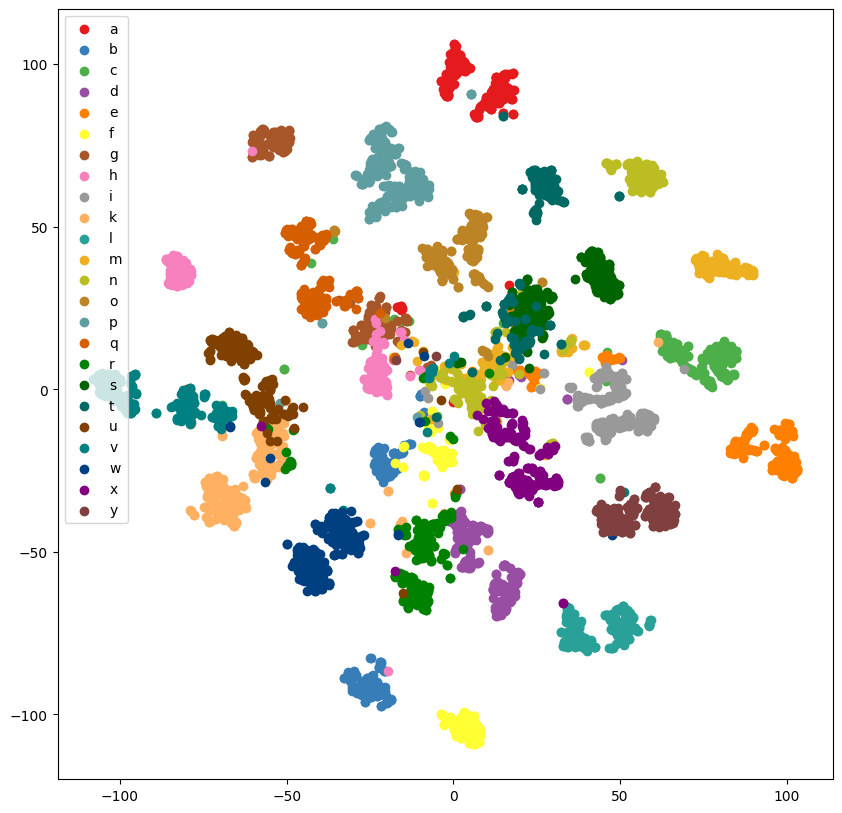

In [23]:
import matplotlib.colors as mcolors
colors = [
    (0.8941, 0.1020, 0.1098),  
    (0.2157, 0.4941, 0.7216),  
    (0.3020, 0.6863, 0.2902), 
    (0.5961, 0.3059, 0.6392), 
    (1.0000, 0.4980, 0.0000), 
    (1.0000, 1.0000, 0.2000),  
    (0.6510, 0.3373, 0.1569),  
    (0.9686, 0.5059, 0.7490), 
    (0.6000, 0.6000, 0.6000), 
    (1.0000, 0.6902, 0.3765),  
    (0.1647, 0.6314, 0.5961),  
    (0.9294, 0.6902, 0.1294), 
    (0.7373, 0.7412, 0.1333),  
    (0.7412, 0.5176, 0.1490),  
    (0.3725, 0.6196, 0.6275), 
    (0.8353, 0.3686, 0.0000),  
    (0.0000, 0.5098, 0.0000), 
    (0.0000, 0.3922, 0.0000),  
    (0.0000, 0.4118, 0.3922),  
    (0.5020, 0.2510, 0.0000),  
    (0.0000, 0.5020, 0.5020), 
    (0.0000, 0.2510, 0.5020),  
    (0.5020, 0.0000, 0.5020),  
    (0.5020, 0.2510, 0.2510),  
]

cmap = mcolors.ListedColormap(colors)


plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    indices = labels == i
    color = cmap(i)  
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], color=color, label=target_name)
plt.legend()
plt.show()